
# MAPIE - How to manage time forecasts

In this tutorial we describe how to use
:class:`~mapie.time_series_regression.MapieTimeSeriesRegressor`
to estimate prediction intervals associated with time series forecast.

Here, we use the Victoria electricity demand dataset used in the book
"Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos.
The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable.

We will use :class:`~MapieTimeSeriesRegressor` to estimate
the prediction intervals associated with one-step ahead forecasts through
the EnbPI and ACI method.

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import (
    coverage_width_based, regression_coverage_score,
    regression_coverage_score_v2, regression_mean_width_score
)
from mapie.regression import MapieTimeSeriesRegressor
from mapie.conformity_scores import AbsoluteConformityScore
from mapie.subsample import BlockBootstrap

warnings.simplefilter("ignore")

from utils.config import SMALL_FIGSIZE, MEDIUM_FIGSIZE, LARGE_FIGSIZE
LARGE_FIGSIZE = (LARGE_FIGSIZE[0]*1.2, LARGE_FIGSIZE[1])

np.random.seed(42)

## 1. Load input data and dataset preparation

The Victoria electricity demand dataset can be downloaded directly on the
MAPIE github repository. It consists in hourly electricity demand (in GW)
of the Victoria state in Australia together with the temperature
(in Celsius degrees). We extract temporal features out of the date and hour.



In [2]:
num_test_steps = 24*7*3

url_file = (
    "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/master/"
    "examples/data/demand_temperature.csv"
)
demand_df = pd.read_csv(
    url_file, parse_dates=True, index_col=0
)
demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)

We now introduce a brutal changepoint in the test set by decreasing the
electricity demand by 2 GW.
It aims at simulating an effect, such as blackout or lockdown due to a
pandemic, that was not taken into account by the model during its training.



In [3]:
demand_df.Demand.iloc[-int(num_test_steps*3/4):] -= 2
demand_df.Demand.iloc[-int(num_test_steps*1/4):] += 2

The last week of the dataset is considered as test set, the remaining data
is used as training set.



In [4]:
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
features = ["Weekofyear", "Weekday", "Hour", "Temperature"]
features += [f"Lag_{hour}" for hour in range(1, n_lags)]

X_train = demand_train.loc[~np.any(demand_train[features].isnull(), axis=1), features]
y_train = demand_train.loc[X_train.index, "Demand"]

history_lenght = 100
X_train = X_train.loc[X_train.index[-history_lenght:], features]
y_train = demand_train.loc[X_train.index[-history_lenght:], "Demand"]
X_test, y_test = demand_test.loc[:, features], demand_test["Demand"]

Let's now visualize the training and test sets with the changepoint.



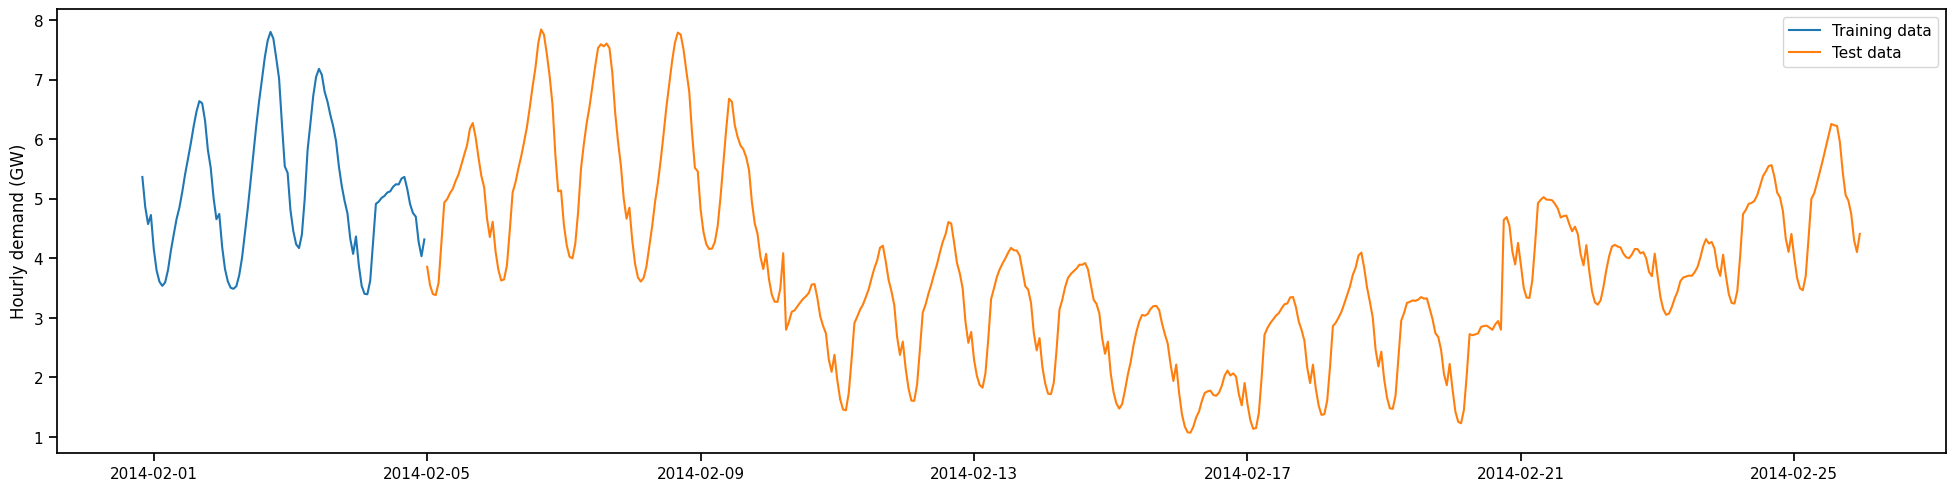

In [5]:
plt.figure(figsize=LARGE_FIGSIZE, layout='constrained')
plt.plot(y_train)
plt.plot(y_test)
plt.ylabel("Hourly demand (GW)")
plt.legend(["Training data", "Test data"])
plt.show()

## 2. Optimize the base estimator

Before estimating the prediction intervals with MAPIE, let's optimize the
base model, here a :class:`~RandomForestRegressor` through a
:class:`~RandomizedSearchCV` with a temporal cross-validation strategy.
For the sake of computational time, the best parameters are already tuned.

In [6]:
model_params_fit_not_done = False
if model_params_fit_not_done:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model, param_distributions=rf_params, n_iter=n_iter, cv=tscv,
        scoring="neg_root_mean_squared_error", random_state=random_state, verbose=0, n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=10, n_estimators=50, random_state=59
    )

## 3. Estimate prediction intervals on the test set

We now use :class:`~MapieTimeSeriesRegressor` to build prediction intervals
associated with one-step ahead forecasts. As explained in the introduction,
we use the EnbPI method and the ACI method.

Estimating prediction intervals can be possible in three ways:

- with a regular ``.fit`` and ``.predict`` process, limiting the use of
  trainining set residuals to build prediction intervals

- using ``.partial_fit`` in addition to ``.fit`` and ``.predict`` allowing
  MAPIE to use new residuals from the test points as new data are becoming
  available.

- using ``.partial_fit`` and ``.adapt_conformal_inference`` in addition to
  ``.fit`` and ``.predict`` allowing MAPIE to use new residuals from the
  test points as new data are becoming available.

The latter method is particularly useful to adjust prediction intervals to
sudden change points on test sets that have not been seen by the model
during training.

We use the :class:`~BlockBootstrap` sampling
method instead of the traditional bootstrap strategy for training the model
since the former is more suited for time series data.
Here, we choose to perform 10 resamplings with 10 blocks.



In [7]:
# Set the risk level (1 - alpha is the confidence level)
alpha = 0.2
# Set the learning rate for the ACI method
gamma = 0.05
# Set the gap between two updates of the conformal inference
gap = 1

# Set the hyperparameters for MAPIE
kwargs_mapie = {
    'conformity_score': AbsoluteConformityScore(sym=False),
    'cv': BlockBootstrap(n_resamplings=10, n_blocks=10, overlapping=False, random_state=59),
    'agg_function': "mean",
    'n_jobs': -1
}
kwargs_fit = {}
kwargs_predict = {
    'alpha': alpha,
    'ensemble': True,
    'optimize_beta': True,
    'allow_infinite_bounds': True
}

The EnbPI method allows you update the residuals during the prediction:
- Each time new observations are available so that the deterioration of
predictions, or the increase of noise level, can be dynamically taken into
account.
- It can be done with :class:`~MapieTimeSeriesRegressor` through
the ``partial_fit`` class method called at every step.

Let's now estimate prediction intervals. The update of the residuals and the one-step ahead predictions
are performed sequentially in a loop.


In [8]:
# Initialize MAPIE class and fit it on the training set (compute conformity scores)
mapie_enbpi = MapieTimeSeriesRegressor(model, method="enbpi", **kwargs_mapie)
mapie_enbpi = mapie_enbpi.fit(X_train, y_train, **kwargs_fit)

# Initialize prediction arrays to keep results
y_pred_enbpi = np.zeros((len(X_test), ))
y_pis_enbpi = np.zeros((len(X_test), 2, 1))

# Step t=0, compute predictions and prediction sets
X_t_ = X_test.iloc[:gap, :]
y_pred_enbpi[:gap], y_pis_enbpi[:gap] = mapie_enbpi.predict(X_t_, **kwargs_predict)

# Step t, compute predictions and prediction sets
for step in range(gap, len(X_test), gap):
    # First, receive true label and update the conformity scores
    cur_indexes = range(step - gap, step)
    X_t_, y_t_ =  X_test.iloc[cur_indexes], y_test.iloc[cur_indexes]
    mapie_enbpi.partial_fit(X_t_, y_t_)

    # Then, compute predictions and prediction sets
    next_indexes = range(step, step + gap)
    X_t_1_ =  X_test.iloc[next_indexes]
    y_pred_enbpi[next_indexes], y_pis_enbpi[next_indexes] = mapie_enbpi.predict(X_t_1_, **kwargs_predict)
    y_pis_enbpi[next_indexes] = np.clip(y_pis_enbpi[next_indexes], 1, 8)

# At the end, computes the coverage and width of the prediction intervals
y_low, y_up = y_pis_enbpi[:, 0, 0], y_pis_enbpi[:, 1, 0]
coverage_enbpi = regression_coverage_score(y_test, y_low, y_up)
width_enbpi = regression_mean_width_score(y_low, y_up)

The ACI strategy allows you to adapt the conformal inference
(i.e the quantile).
- If the real values are not in the coverage,
the size of the intervals will grow.
- Conversely, if the real values are in the coverage,
the size of the intervals will decrease.
You can use a gamma coefficient to adjust the strength of the correction.
- It can be done with :class:`~MapieTimeSeriesRegressor` through
the ``partial_fit`` and ``adapt_conformal_inference`` class methods called at every step.

Let's now estimate prediction intervals. As discussed
previously, the update of the residuals and the one-step ahead predictions
are performed sequentially in a loop.



In [9]:
# Initialize MAPIE class and fit it on the training set (compute conformity scores)
mapie_aci = MapieTimeSeriesRegressor(model, method="aci", **kwargs_mapie)
mapie_aci = mapie_aci.fit(X_train, y_train, **kwargs_fit)

# Initialize prediction arrays to keep results
y_pred_aci = np.zeros((len(X_test), ))
y_pis_aci = np.zeros((len(X_test), 2, 1))

# Step t=0, compute predictions and prediction sets
X_t_ = X_test.iloc[:gap, :]
y_pred_aci[:gap], y_pis_aci[:gap] = mapie_aci.predict(X_t_, **kwargs_predict)

# Step t, compute predictions and prediction sets
for step in range(gap, len(X_test), gap):
    # First, receive true label and update the conformity scores
    cur_indexes = range(step - gap, step)
    X_t_, y_t_ =  X_test.iloc[cur_indexes], y_test.iloc[cur_indexes]
    # 1) Update the conformity scores
    mapie_aci.partial_fit(X_t_, y_t_)
    # 2) Update the value of alpha (update specific to ACI)
    mapie_aci.adapt_conformal_inference(X_t_.to_numpy(), y_t_.to_numpy(), gamma=gamma)

    # Then, compute predictions and prediction sets
    next_indexes = range(step, step + gap)
    X_t_1_ =  X_test.iloc[next_indexes]
    y_pred_aci[next_indexes], y_pis_aci[next_indexes] = mapie_aci.predict(X_t_1_, **kwargs_predict)
    y_pis_aci[next_indexes] = np.clip(y_pis_aci[next_indexes], 1, 8)

# At the end, computes the coverage and width of the prediction intervals
y_low, y_up = y_pis_aci[:, 0, 0], y_pis_aci[:, 1, 0]
coverage_aci = regression_coverage_score(y_test, y_low, y_up)
width_aci = regression_mean_width_score(y_low, y_up)

## 4. Plot estimated prediction intervals on one-step ahead forecast

Let's now compare the prediction intervals estimated by MAPIE.

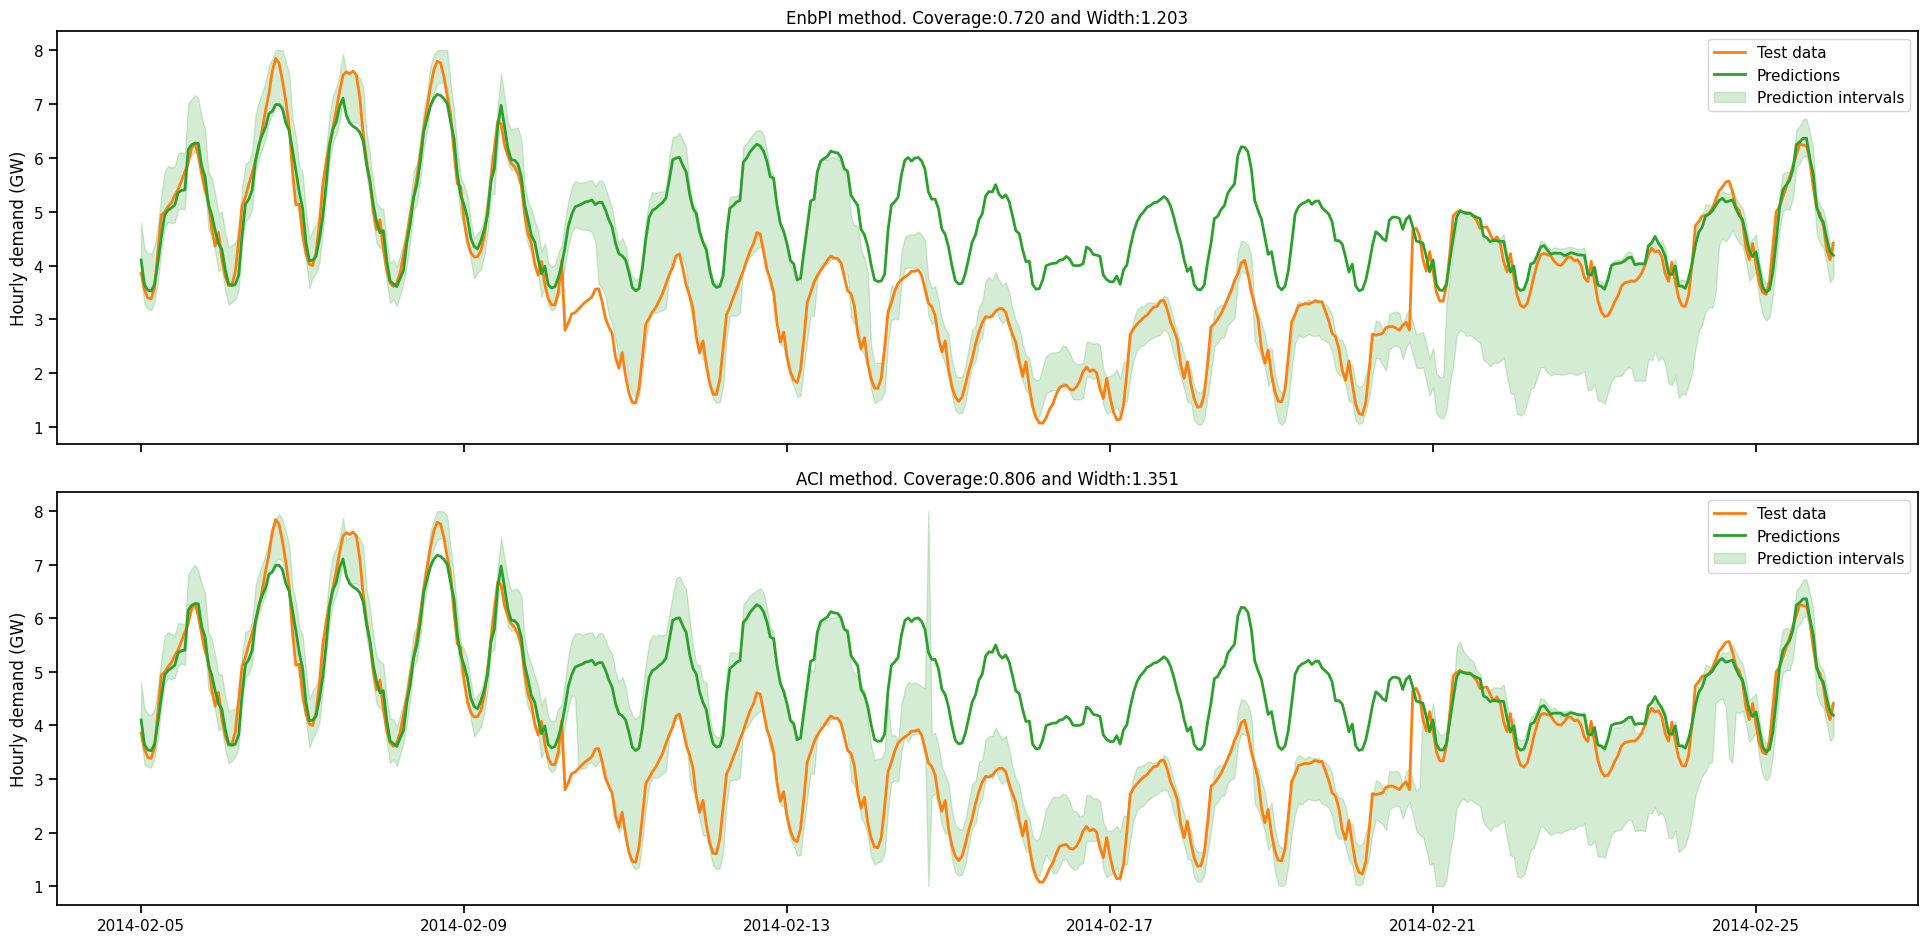

In [10]:
y_meth_preds = [y_pred_enbpi, y_pred_aci]
y_meth_pis = [y_pis_enbpi, y_pis_aci]
coverages_meth = [coverage_enbpi, coverage_aci]
widths_meth = [width_enbpi, width_aci]

figsize = (LARGE_FIGSIZE[0], 2*LARGE_FIGSIZE[1])
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize, sharey="row", sharex="col", layout='constrained')

for i, (ax, w) in enumerate(zip(axs, ["EnbPI", "ACI"])):
    ax.set_ylabel("Hourly demand (GW)")
    # Plot the true label
    ax.plot(y_test, lw=2, label="Test data", c="C1")
    # Plot the predictions
    ax.plot(y_test.index, y_meth_preds[i], lw=2, c="C2", label="Predictions")
    # Plot the predictions intervals
    ax.fill_between(
        y_test.index, y_meth_pis[i][:, 0, 0], y_meth_pis[i][:, 1, 0],
        color="C2", alpha=0.2, label="Prediction intervals",
    )
    # Add labels and title
    title = f"{w} method. Coverage:{coverages_meth[i]:.3f} and Width:{widths_meth[i]:.3f}"
    ax.set_title(title)
    ax.legend()

fig.tight_layout()
plt.show()

Let's now compare the coverages obtained by MAPIE with and without update
of the residuals on a 24-hour rolling window of prediction intervals.



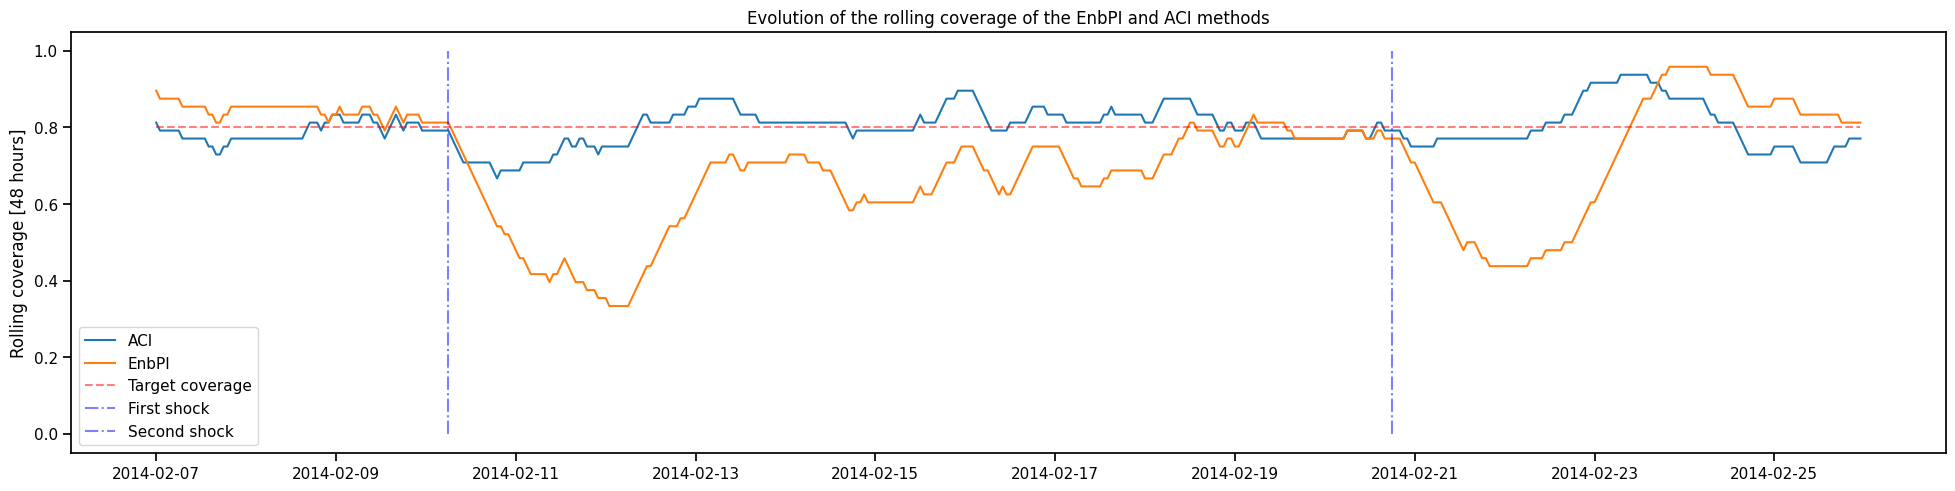

In [11]:
window = 24*2
rolling_coverage_aci, rolling_coverage_enbpi = [], []

for i in range(window, len(y_test), 1):
    # Calculate the range of the window
    indexes = range(np.max([0, i-window]), np.min([i, len(y_test)]))

    # Compute the coverage of EnbPI method on the window
    coverage_enbpi = regression_coverage_score_v2(y_test[indexes], y_pis_enbpi[indexes])
    rolling_coverage_enbpi.append(coverage_enbpi)
    
    # Compute the coverage of ACI method on the window
    coverage_aci = regression_coverage_score_v2(y_test[indexes], y_pis_aci[indexes])
    rolling_coverage_aci.append(coverage_aci)

time_indexes = y_test[window:].index

plt.figure(figsize=LARGE_FIGSIZE, layout='constrained')
# Plot rolling coverage of the methods
plt.plot(time_indexes, rolling_coverage_aci, label="ACI", linestyle='-')
plt.plot(time_indexes, rolling_coverage_enbpi, label="EnbPI", linestyle='-')
# Plot the target coverage
plt.hlines(y=1-alpha, xmin=time_indexes[0], xmax=time_indexes[-1], color='red', alpha=0.5, linestyle='--', label="Target coverage")
# Plot the change points
plt.vlines(x=time_indexes[-int(num_test_steps*3/4)], ymin=0, ymax=1, color='b', alpha=0.5, linestyle='-.', label="First shock")
plt.vlines(x=time_indexes[-int(num_test_steps*1/4)], ymin=0, ymax=1, color='b', alpha=0.5, linestyle='-.', label="Second shock")
# Add labels and title
plt.ylabel(f"Rolling coverage [{window} hours]")
plt.title("Evolution of the rolling coverage of the EnbPI and ACI methods")
plt.legend()

plt.show()

The training data do not contain a change point, hence the base model cannot
anticipate it.
Without update of the residuals, the prediction intervals are built upon the
distribution of the residuals of the training set.
Therefore they do not cover the true observations after the change point,
leading to a sudden decrease of the coverage.
However, the partial update of the residuals allows the method to capture the
increase of uncertainties of the model predictions.
One can notice that the uncertainty's explosion happens about one day late.
This is because enough new residuals are needed to change the quantiles
obtained from the residuals distribution.

